# Denoising Shabby Pages

https://www.kaggle.com/competitions/denoising-shabby-pages
https://wandb.ai/dbrambilla13/shabby-pages?workspace=user-dbrambilla13
https://github.com/dbrambilla13/denoising-shabby-pages

In [2]:
import torch
import torchvision

In [3]:
import os
from tqdm import tqdm

# Dataset

In [4]:
from torch.utils.data import Dataset, DataLoader
import json

from torchvision import transforms 
import torchvision.transforms.functional as TF

import random


class ShabbyPagesDataset(Dataset):

    def __init__(self, split="train", augment=False, crop_ratio=0.8, rotation_angle=90, flip_probability=0.5):
        super().__init__()

        self.augment = augment
        self.crop_ratio = crop_ratio
        self.rotation_angle = rotation_angle
        self.flip_probability = flip_probability


        self.folder_shabby = f"{split}/{split}/{split}_shabby/"
        self.folder_clean = f"{split}/{split}/{split}_cleaned/"

        self.image_dict = {}
        for idx, image_name in enumerate(os.listdir(self.folder_shabby)):
            self.image_dict[idx] = image_name

        with open(f"{split}_image_dict.json", "w") as f:
            json.dump(self.image_dict, f)

    def transform(self, input_img, target_img):
        
        # Random crop
        i, j, h, w = transforms.RandomCrop.get_params(
            input_img, output_size=(int(400*self.crop_ratio), int(400*self.crop_ratio)))
        input_img = TF.crop(input_img, i, j, h, w)
        target_img = TF.crop(target_img, i, j, h, w)

        # Random horizontal flipping
        if random.random() < self.flip_probability:
            input_img = TF.hflip(input_img)
            target_img = TF.hflip(target_img)

        # Random vertical flipping
        if random.random() < self.flip_probability:
            input_img = TF.vflip(input_img)
            target_img = TF.vflip(target_img)

        # Random Rotation 
        angle = random.randint(-90,+90)
        input_img = TF.rotate(input_img, angle)
        target_img = TF.rotate(target_img, angle)

        return input_img, target_img

    def __len__(self):
        return len(self.image_dict)

    def __getitem__(self, idx):
        input_sample = (
            torchvision.io.read_image(
                os.path.join(self.folder_shabby, self.image_dict[idx])
            ).to(dtype=torch.float32)
        )/255.0
        target_sample = (
            torchvision.io.read_image(
                os.path.join(self.folder_clean, self.image_dict[idx])
            ).to(dtype=torch.float32)
        )/255.0

        if self.augment:
            return self.transform(input_sample,target_sample)
        else:
            return input_sample, target_sample

In [5]:
train_dataset = ShabbyPagesDataset(split="train", augment=True)
train_dataloader = DataLoader(
    dataset=train_dataset, batch_size=16, shuffle=True, num_workers=8
)

test_dataset = ShabbyPagesDataset(split="train")
test_dataloader = DataLoader(
    dataset=test_dataset, batch_size=16, shuffle=False, num_workers=8
)


validate_dataset = ShabbyPagesDataset(split="train")
validate_dataloader = DataLoader(
    dataset=validate_dataset, batch_size=16, shuffle=False, num_workers=8
)

# deep learning model

In [6]:
from typing import Any
from torch.nn import (
    Conv2d,
    ConvTranspose2d,
    MaxPool2d,
    MaxUnpool2d,
    BatchNorm2d,
    MSELoss,
    ReLU,
    Sigmoid,
    Dropout2d,
)

import lightning


class ConvNet(torch.nn.Module):

    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)

        # encoder

        self.bn0 = BatchNorm2d(num_features=1)
        self.conv1 = Conv2d(in_channels=1, out_channels=32, kernel_size=5, padding=2)
        self.bn1 = BatchNorm2d(num_features=32)
        self.drop1 = Dropout2d(p=0.3)
        self.pool1 = MaxPool2d(2, 2, return_indices=True)

        self.conv2 = Conv2d(in_channels=32, out_channels=128, kernel_size=5, padding=2)
        self.bn2 = BatchNorm2d(num_features=128)
        self.drop2 = Dropout2d(p=0.3)
        self.pool2 = MaxPool2d(2, 2, return_indices=True)

        self.conv3 = Conv2d(in_channels=128, out_channels=256, kernel_size=5, padding=2)
        self.bn3 = BatchNorm2d(num_features=256)
        self.drop3 = Dropout2d(p=0.3)
        self.pool3 = MaxPool2d(2, 2, return_indices=True)

        # decoder

        self.tconv1 = ConvTranspose2d(
            in_channels=256, out_channels=128, kernel_size=5, padding=2
        )
        self.tbn1 = BatchNorm2d(num_features=128)
        self.tdrop1 = Dropout2d(p=0.3)
        self.tpool1 = MaxUnpool2d(2, 2)
        self.tconv2 = ConvTranspose2d(
            in_channels=128, out_channels=32, kernel_size=5, padding=2
        )

        self.tbn2 = BatchNorm2d(num_features=32)
        self.tdrop2 = Dropout2d(p=0.3)
        self.tpool2 = MaxUnpool2d(2, 2)
        self.tconv3 = ConvTranspose2d(
            in_channels=32, out_channels=1, kernel_size=5, padding=2
        )
        self.tbn3 = BatchNorm2d(num_features=1)
        self.tpool3 = MaxUnpool2d(2, 2)

    def forward(self, x):

        # encoder
        x = self.bn0(x)

        x = self.conv1(x)
        x = self.bn1(x)
        # x = self.drop1(x)
        x = torch.relu(x)
        x, ind1 = self.pool1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        # x = self.drop2(x)
        x = torch.relu(x)
        x, ind2 = self.pool2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        # x = self.drop3(x)
        x = torch.relu(x)
        x, ind3 = self.pool3(x)

        # decoder

        x = self.tpool1(x, ind3)
        x = self.tconv1(x)
        x = self.tbn1(x)
        # x = self.tdrop1(x)
        x = torch.relu(x)
        # print(1)
        x = self.tpool2(x, ind2)
        x = self.tconv2(x)
        x = self.tbn2(x)
        # x = self.tdrop2(x)
        x = torch.relu(x)
        # print(2)
        x = self.tpool3(x, ind1)
        x = self.tconv3(x)
        x = self.tbn3(x)
        x = torch.relu(x)
        # print(x.size())
        # print(ind1.size())
        # print(3)
        x = torch.sigmoid(x)

        return x


class DenoisingNet(lightning.LightningModule):
    def __init__(self):
        super().__init__()

        self.cnet = ConvNet()

        self.mse_loss = MSELoss()

    def forward(self, x):

        x = self.cnet(x)

        return x

    def training_step(self, batch, batch_idx):
        # training_step defines the train loop.
        x, y = batch
        y_hat = self.forward(x)
        loss = self.mse_loss(y_hat, y)
        self.log("mse_train", loss, prog_bar=True, on_epoch=True, on_step=False)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        loss = self.mse_loss(y_hat, y)
        self.log("mse_val", loss, prog_bar=True, on_epoch=True, on_step=False)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.005)
        return optimizer


# model
model = DenoisingNet()

In [7]:
# model testing

for x,y in train_dataloader:
    model(x)
    break

In [8]:
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping
from lightning.pytorch.loggers import WandbLogger


early_stopping = EarlyStopping(
    # monitor='valid_mse',
    monitor="mse_val",
    patience=25,
    mode="min",
)

checkpoint_callback = ModelCheckpoint(
    dirpath="saved_models/",
    monitor="mse_val",
    mode="min",
    filename="{epoch}-{mse_val:.3f}",
    auto_insert_metric_name=True,
)

wandb_logger = WandbLogger(project="shabby-pages")


trainer = lightning.Trainer(
    max_epochs=250,
    # accelerator=device,
    precision="16-mixed",
    logger=wandb_logger,
    callbacks=[early_stopping, checkpoint_callback],
)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [8]:


# train model

trainer.fit(model=model, train_dataloaders=train_dataloader, val_dataloaders=validate_dataloader)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: dbrambilla13. Use `wandb login --relogin` to force relogin


/home/daniele/personal/git/denoising-shabby-pages/.env/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/daniele/personal/git/denoising-shabby-pages/saved_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type    | Params
-------------------------------------
0 | cnet     | ConvNet | 1.8 M 
1 | mse_loss | MSELoss | 0     
-------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.386     Total estimated model params size (MB)


Epoch 249: 100%|██████████| 62/62 [00:27<00:00,  2.29it/s, v_num=7ybu, mse_val=0.0195, mse_train=0.0462]

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 249: 100%|██████████| 62/62 [00:27<00:00,  2.29it/s, v_num=7ybu, mse_val=0.0195, mse_train=0.0462]


# Model Evaluation

In [9]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F


In [13]:
trained_model = DenoisingNet.load_from_checkpoint('pretty-elevator-27-epoch=236-mse_val=0.017.ckpt').eval().cpu()

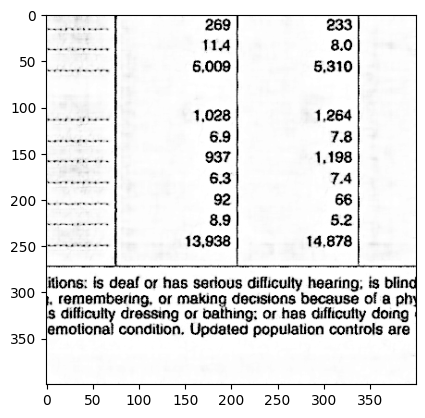

In [17]:


for x, y in test_dataset:
    # print(x.shape)
    # img=x
    # img=y
    img = trained_model(x.detach().cpu().unsqueeze(0))
    # img = y.unsqueeze(0)

    img = F.to_pil_image(img.squeeze(0), mode="L")
    plt.imshow(img, cmap="gray")
    plt.show()
    break